In [1]:
import torch
from fastai.vision.all import *
import numpy as np
from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### In this Notebook we wanted to test the differences of performance of our original Model trained on cars and the original Model which we later also trained for 5 epochs on an external Dataset that was a little bit different to ours (see notebook Twente_Car_Model.ipynb)

### Original Model

In [2]:
# function to get the masks with the streets
def mask_function(name):
    return np.load(str(name).replace("img.png", "label.npy"))

In [4]:
#function to get the images
def get_images(name):
    return get_image_files(name)

In [5]:
#path to the data
path = Path("/kaggle/input/tds-masks/train_test_split")
train_path = path/"train"
test_path = path/"test"

In [7]:
#path to original model
model_path = '/kaggle/input/modell/best_model'

In [8]:
#path to model retrained on external data
twente_model_path='/kaggle/input/modell-twente/best_trained_model'

In [6]:
# creating a datablock based on the masks
satellite_block = DataBlock(blocks=(ImageBlock, MaskBlock(codes=["background", "car"])),
                            get_items=get_image_files,
                            splitter=GrandparentSplitter(train_name='train', valid_name='test'),
                            get_y=mask_function,
                            batch_tfms=aug_transforms(size=500, max_lighting=0.3)
                            )


In [9]:
#create the dataloader based on the datablock
dataloader = satellite_block.dataloaders(path, bs=8)

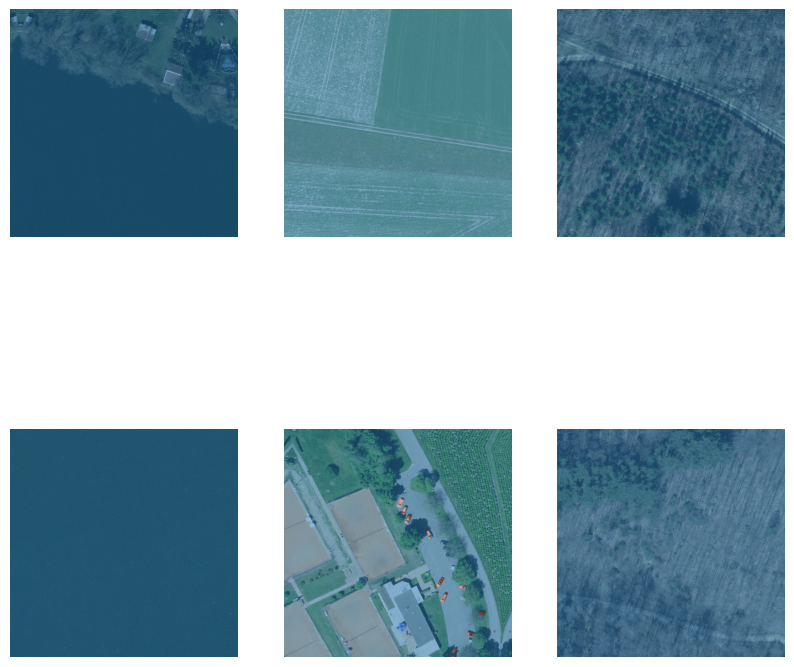

In [10]:
dataloader.show_batch(max_n=6, figsize=(10,10))

In [8]:
#create a learner
learner = unet_learner(dataloader,resnet34,metrics=Dice)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 28.9MB/s]


In [9]:
#load the original Modell
learner.load(model_path)

/opt/conda/lib/python3.10/site-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


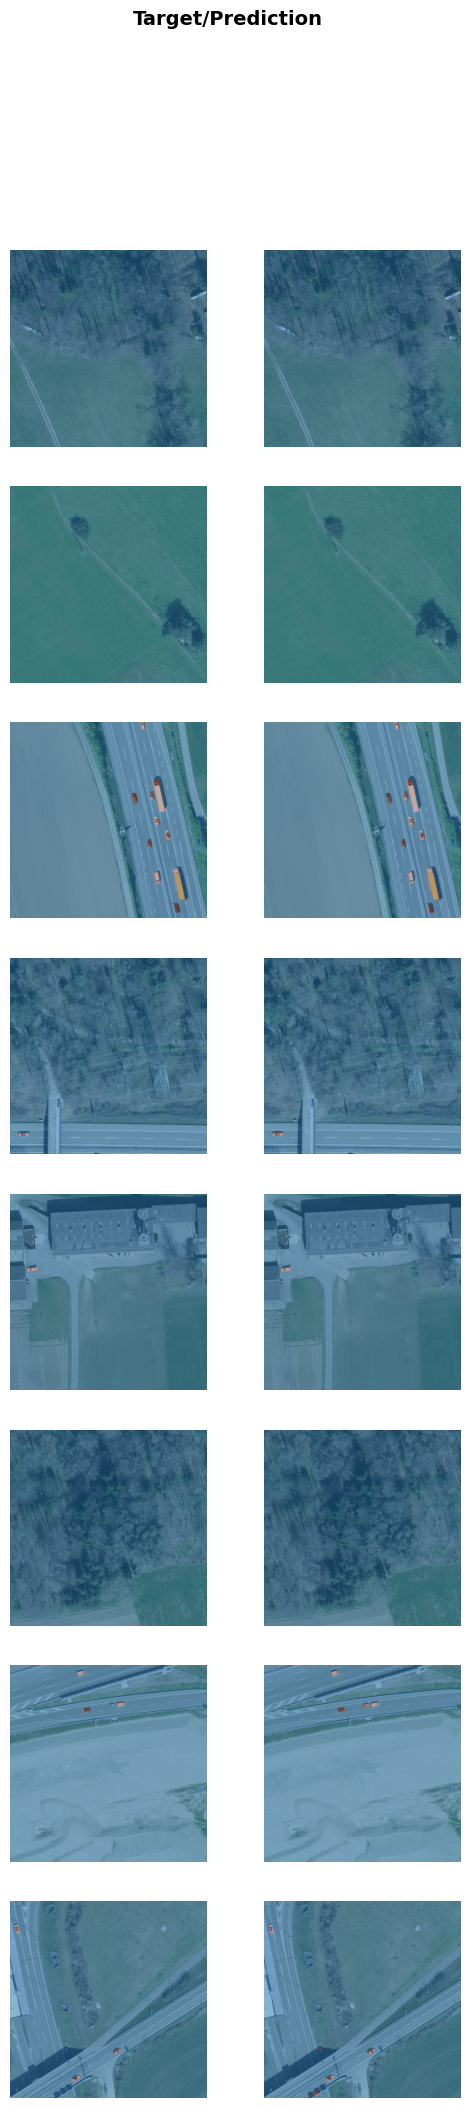

In [10]:
# show the predictions
learner.show_results(max_n=10)

### evaluating the performance via the dice score

In [11]:
print("out-of-sample performance: {}".format(np.array(learner.validate(ds_idx=1)[1]))) # Dice Score

in-sample performance: 0.7784038047403109


In [13]:
print("In-Sample Performance: {}".format(np.array(learner.validate(ds_idx=0)[1])))  # Dice Score

In-Sample Performance: 0.8320185491178509


## Twente Model


In [11]:
#create a learner
learner_twente = unet_learner(dataloader,resnet34,metrics=Dice)

In [14]:
#load the learner based on the model, that was retrained on external data
learner_twente.load(twente_model_path)

/opt/conda/lib/python3.10/site-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


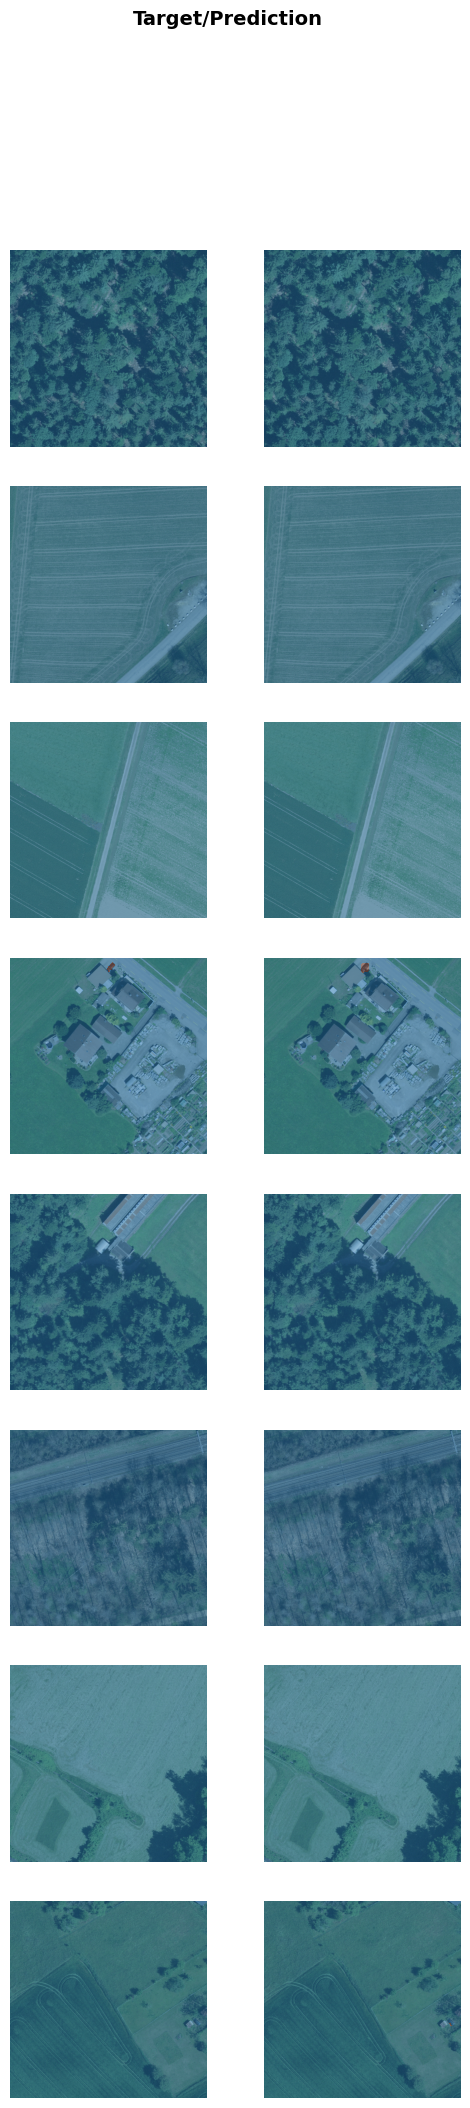

In [17]:
# show the predictions
learner_twente.show_results(max_n=10)

### evaluating the performance via the dice score

In [20]:
print("out-of-sample performance: {}".format(np.array(learner_twente.validate(ds_idx=1)[1])))

out-of-sample performance: 0.5536530301817308


In [22]:
print("In-Sample Performance: {}".format(np.array(learner_twente.validate(ds_idx=0)[1])))

In-Sample Performance: 0.5821762793171938


#### as you can see the performance after the retraining on the external dataset is a bit weaker. Therfore the performance is better on the external data (as you can see in Twente_Car_Model.ipynb). Since the external Dataset uses bounding boxes as masks and we use polygons it is only logical that the performance is weaker. The external Data sometimes also uses spatial pictures that were taken with a angel while all of our data was taken straight from the top